# Relatório de Análise de Churn de Clientes - Telecom X


### Objetivo da Análise

Este relatório apresenta uma análise abrangente dos dados de evasão de clientes (churn) da empresa Telecom X, com o objetivo de identificar padrões e fatores que contribuem para a perda de clientes. A análise visa fornecer insights acionáveis que possam ser utilizados pela equipe de Data Science para desenvolver estratégias eficazes de retenção de clientes e redução da taxa de evasão.

### Contextualização do Problema

A evasão de clientes, conhecida no mercado como "churn", representa um dos principais desafios enfrentados por empresas de telecomunicações. Este fenômeno ocorre quando clientes decidem cancelar seus serviços e migrar para concorrentes, impactando diretamente a receita da empresa e aumentando os custos de aquisição de novos clientes. A Telecom X vem enfrentando altas taxas de evasão e necessita compreender os fatores que contribuem para esse cenário.

###  Escopo da Análise

Esta análise exploratória abrange todo o processo de ETL (Extract, Transform, Load), desde a extração dos dados da API da empresa até a identificação de padrões e insights relevantes. O trabalho inclui tratamento de dados, análise estatística descritiva, visualizações e recomendações estratégicas baseadas nos achados.

In [60]:
#  importações necessárias
import pandas as pd
import matplotlib.pyplot as plt
import plotly as plty
import seaborn as sns
import  numpy as np

#  carregando o df e conhecendo os dados
df=pd.read_json('https://github.com/alura-cursos/challenge2-data-science/raw/c28f6884bd0f6908832b324eb9d9c7f42e345d3e/TelecomX_Data.json')
df.columns
display(df. head(3))

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


Os dados foram importados mas estão completamente embaralhados e sem formatação adequada, em seguida vamos organizar em um Data Frame adequado para análise

In [61]:
#  normalizando dados
pa_df_customer =pd.json_normalize(df['customer'])
pa_df_phone =pd.json_normalize(df['phone'])
pa_df_internet =pd.json_normalize(df['internet'])
pa_df_account =pd.json_normalize(df['account'])

# concatenando horizontalmente os todos os df para um único df orientado ao index
part_df=df[['customerID','Churn']]
df = pd.concat([part_df,pa_df_customer, pa_df_phone, pa_df_internet, pa_df_account], axis=1)

# verifica tipo de dados e converte para outro tipo de dados
df.isnull().sum()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


In [62]:
display(df.head(3))

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


### Convertendo os dados para tipos adequados para análise
Observe que agora o Data Frame está com as colunas organizadas e estruturado, porém ele está em uma formatação inadequada de tipos de dados. A seguir vamos converter os dados

In [63]:
#   A coluna 'Charges.Total' possuia strings nulas, iremos converter para 0 para transformar toda coluna para o tipo float
df['Charges.Total']=df['Charges.Total'].replace(['',' '],0)
df['Charges.Total'] = df['Charges.Total'].astype(np.float64)


#  criando a coluna contas diárias 'day_account'
df['day_account']= df['Charges.Total'] /30

#  colunas para binários:
colunas_binários=[ 'Churn',  'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

#  verificando os Valores únicos das colunas para ver a conversão direta para binário é possível ou precisa de mais tratamento de dados
[df[x].unique() for x in colunas_binários]

#  como a coluna 'Churn'(Evasão de clientes da empresa) teve valores string nulos, troquei esses valores para 1 pois provavelmente os clientes não deixaram a empresa e não tem grande impácto nos dados estatísticos por certa de 200 dos 7267 
df['Churn'].unique()
df['Churn']=df['Churn'].replace('', 1)

#  Convertendo todas as colunas de colunas_binários para binário com 'Yes' =1 e 'No' = 0   e reduzindo o espaço dos dados int64 para int8 na memória
df[colunas_binários]=df[colunas_binários].applymap(lambda x: 1 if x=='Yes' else 0).astype('int8')
df['SeniorCitizen'].astype('int8')

# Os dados foram tratados  e convertidos para o tipo de dado correto para análise
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   int8   
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   int8   
 5   Dependents        7267 non-null   int8   
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   int8   
 8   MultipleLines     7267 non-null   int8   
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   int8   
 13  TechSupport       7267 non-null   int8   
 14  StreamingTV       7267 non-null   int8   
 15  StreamingMovies   7267 non-null   int8   
 16  Contract          7267 non-null   object 


C:\Users\victo\AppData\Local\Temp\ipykernel_2364\2216708798.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[colunas_binários]=df[colunas_binários].applymap(lambda x: 1 if x=='Yes' else 0).astype('int8')


##  Limpeza e Tratamento de Dados

###  Tratamento da Coluna 'Charges.Total'
- Substituição de valores nulos (strings vazias) por 0
- Conversão do tipo de dados para float64 para análise numérica

###  Criação de Variável Derivada
- Criação da coluna 'day_account' calculando o valor diário das contas (Charges.Total / 30)

###  Conversão de Variáveis Categóricas para Binárias
- Identificação de 10 colunas categóricas com valores 'Yes'/'No'
- Tratamento especial da coluna 'Churn': valores nulos substituídos por 1 (assumindo não-evasão)
- Conversão automática: 'Yes' = 1, 'No' = 0
- Otimização de memória: conversão de int64 para int8


Agora os dados estão padronizados e convertidos para tipos apropriados e o Dataset está preparado para análise exploratória com variáveis numéricas e binárias otimizadas

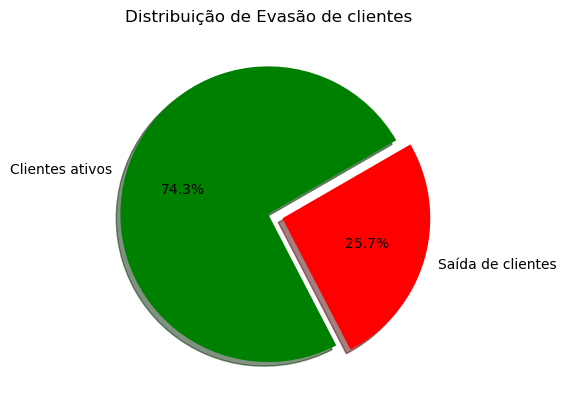

In [64]:

#  filtrando df para somente pegar grupo de clientes que tiveram evasão
client_Churn=df[df['Churn']==1]
client_on=df[df['Churn']==0]
client_on['Contract'].value_counts()


#  gráfico tipo pie com porcentagem de saída de clientes da empresa
fig, ax = plt.subplots()
plt.title('Distribuição de Evasão de clientes')
ax.pie(df['Churn'].value_counts(), labels=['Clientes ativos','Saída de clientes'],autopct='%1.1f%%',
        colors=['green', 'red'], explode=(0,0.1), shadow=True,  startangle=30)
plt.show()


Nesta primeira análise gráfica, podemos observar uma considerável saída de clientes da empresa, cerca de 1/4 dos clientes saíram (Clientes Evasivos)

##### A seguir veremos como a evasão se distribui de acordo com variáveis categóricas, como gênero, tipo de contrato, método de pagamento. Isso relacionado aos clientes evasivos (clientes que saíram da empresa)


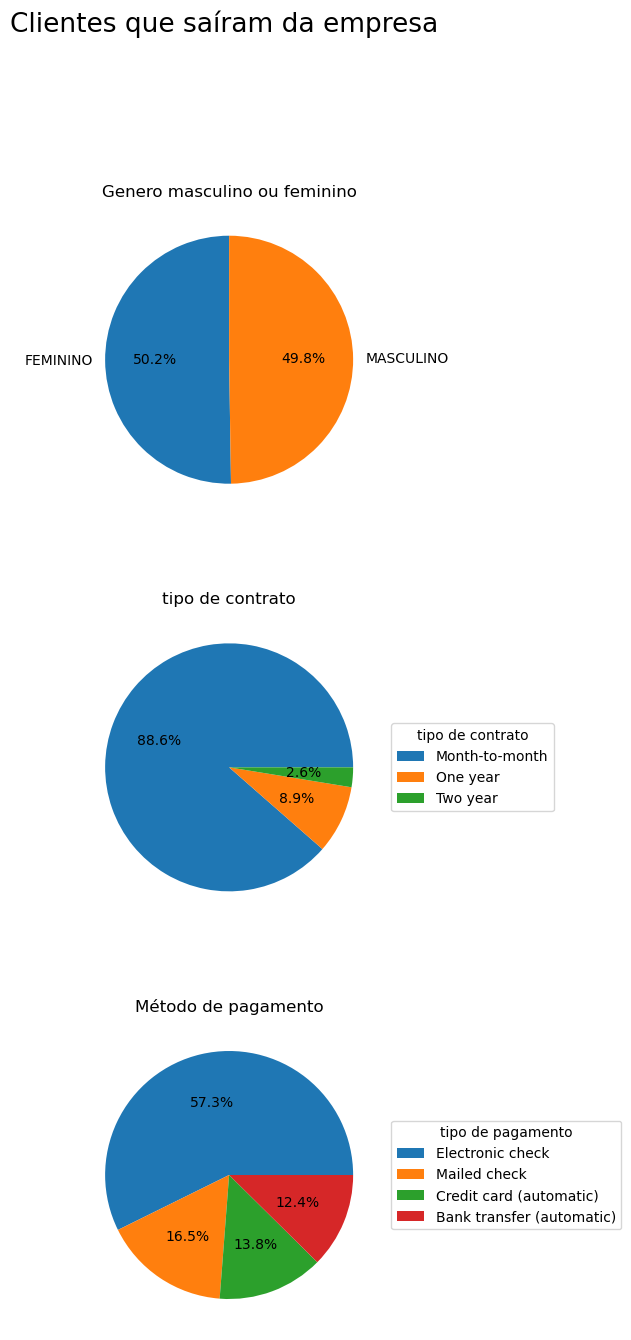

In [65]:


fig, axs = plt.subplots(3,1, figsize=(4,15))
fig.suptitle('Clientes que saíram da empresa', fontsize=19, y=1.00)

axs[0].pie(client_Churn['gender'].value_counts(), labels=['FEMININO','MASCULINO'],autopct='%1.1f%%', startangle=90)
axs[0].set_title('Genero masculino ou feminino')

axs[1].pie(client_Churn['Contract'].value_counts(),autopct='%1.1f%%')
axs[1].set_title('tipo de contrato')
axs[1].legend(labels=['Month-to-month','One year', 'Two year'],title="tipo de contrato",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1)) 

axs[2].pie(client_Churn['PaymentMethod'].value_counts(),autopct='%1.1f%%')
axs[2].set_title('Método de pagamento')
axs[2].legend(labels=client_Churn['PaymentMethod'].unique(),title="tipo de pagamento",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1)) 

plt.show()

####  podemos perceber que a predominancia dos clientes que saíram da empresa  88.6% possuiam o contrato mês a mês e 57% deles usavam o método de pagamento Cheque eletrônico, em relação ao gênero não teve diferença significativa


A seguir veremos agora a essa mesma proporção mas dos clientes ainda ativos na empresa


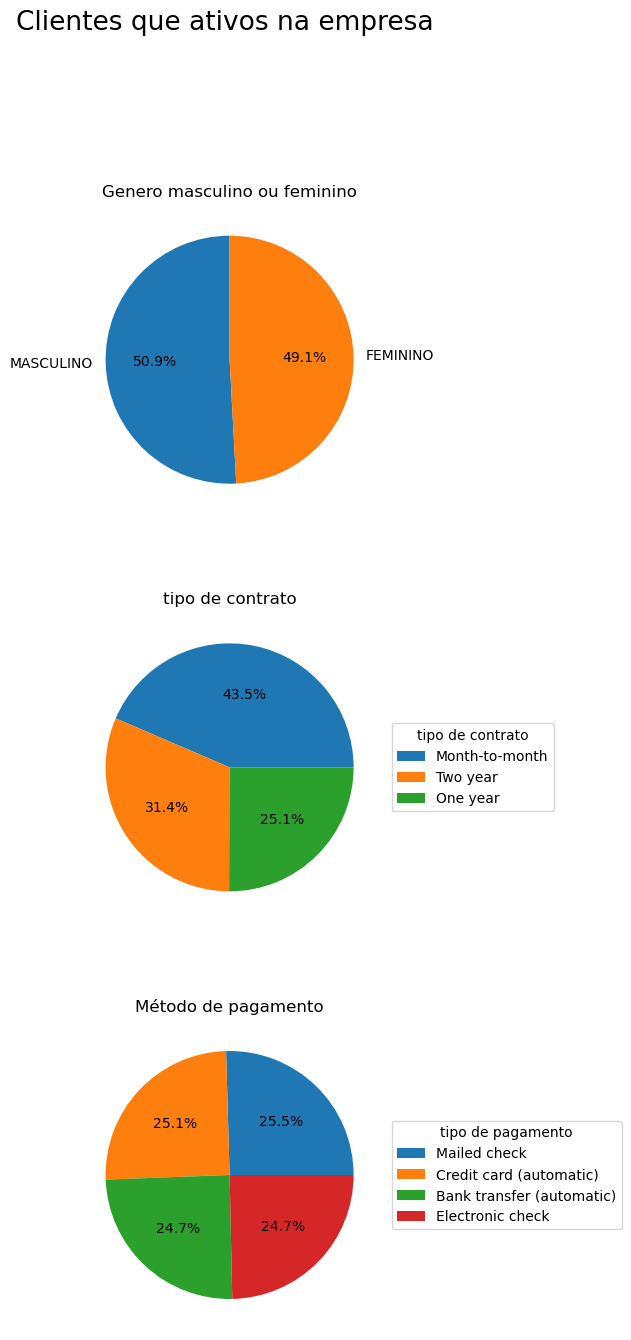

In [66]:

fig, axs = plt.subplots(3,1, figsize=(4,15))
# fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.suptitle('Clientes que ativos na empresa', fontsize=19, y=1.00)

axs[0].pie(client_on['gender'].value_counts(), labels=['MASCULINO','FEMININO'],autopct='%1.1f%%', startangle=90)
axs[0].set_title('Genero masculino ou feminino')

axs[1].pie(client_on['Contract'].value_counts(),autopct='%1.1f%%')
axs[1].set_title('tipo de contrato')
axs[1].legend(labels=client_on['Contract'].value_counts().keys(),title="tipo de contrato",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1)) 

axs[2].pie(client_on['PaymentMethod'].value_counts(),autopct='%1.1f%%')
axs[2].set_title('Método de pagamento')
axs[2].legend(labels=client_on['PaymentMethod'].unique(),title="tipo de pagamento",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1)) 

plt.show()

#### Na análise que os clientes que se mantiveram na empresa podemos notar uma maior distribuição igualitária nos dados como método de pagamento e no tipo de contrato teve uma maior proporção dos tipos de contrato como 2 anos 31,4% e contrato de 1 ano de 25.1%  isso sugere que os clientes que fecham contratos de 1 ou 2 anos tem menores chances de sair da empresa 


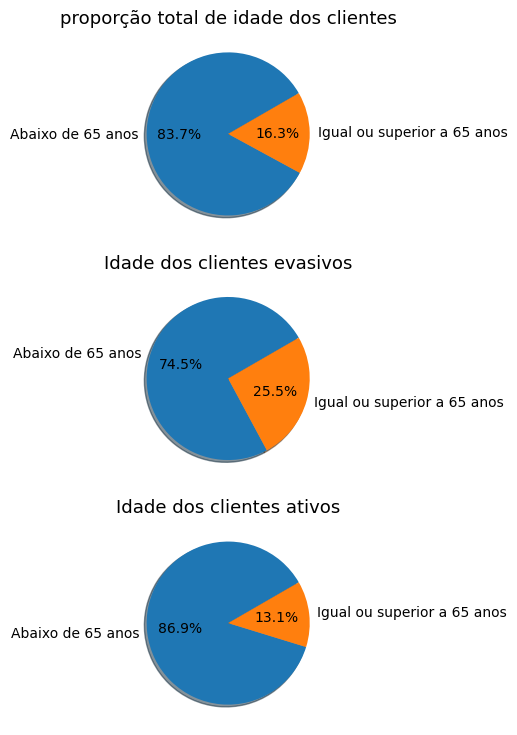

In [68]:

#   clienques que saíram idade superior a 65 anos
fig, ax = plt.subplots(3,1, figsize=(10,9))
ax[0].set_title('proporção total de idade dos clientes', fontsize=13)
ax[0].pie(df['SeniorCitizen'].value_counts(), labels=['Abaixo de 65 anos','Igual ou superior a 65 anos'],autopct='%1.1f%%',
         shadow=True,  startangle=30)

ax[1].set_title('Idade dos clientes evasivos',fontsize=13 )
ax[1].pie(client_Churn['SeniorCitizen'].value_counts(), labels=['Abaixo de 65 anos','Igual ou superior a 65 anos'],autopct='%1.1f%%',
         shadow=True,  startangle=30)

ax[2].set_title('Idade dos clientes ativos',fontsize=13 )
ax[2].pie(client_on['SeniorCitizen'].value_counts(), labels=['Abaixo de 65 anos','Igual ou superior a 65 anos'],autopct='%1.1f%%',
         shadow=True,  startangle=30)

plt.show()

 A predominância da proporção de idade dos clientes é abaixo dos 65 anos com 83.7%. O fator idade não foi relevante para a análise relacionada a Evasão



A seguir Analisaremos  o gasto total dos grupos de clientes

C:\Users\victo\AppData\Local\Temp\ipykernel_2364\3872231829.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, y='Charges.Total', x='Churn', palette=['green', 'red'])
C:\Users\victo\AppData\Local\Temp\ipykernel_2364\3872231829.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Cliente Ativo', 'Cliente Evasivo'])


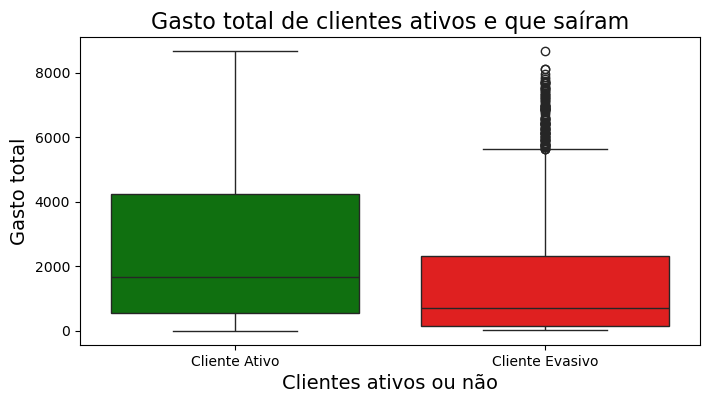

In [ ]:
#  gasto total de clientes ativos e que saíram da empresa
fig, ax = plt.subplots(figsize=(8, 4))

ax = sns.boxplot(data=df, y='Charges.Total', x='Churn', palette=['green', 'red'])
ax.set_title('Gasto total de clientes ativos e que saíram', fontsize=16)
ax.set_ylabel('Gasto total', fontsize=14)
ax.set_xlabel('Clientes ativos ou não', fontsize=14)
ax.set_xticklabels(['Cliente Ativo', 'Cliente Evasivo'])


Nesta análise podemos notar facilmente que os clientes que se mantem por mais tempo de contrato, possuem maior aderência na empresa


A seguir veremos a relação de tempo de contrato

C:\Users\victo\AppData\Local\Temp\ipykernel_2364\2178252246.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, y='tenure', x='Churn', palette=['green', 'red'])
C:\Users\victo\AppData\Local\Temp\ipykernel_2364\2178252246.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Cliente Ativo', 'Cliente Evasivo'])


[Text(0, 0, 'Cliente Ativo'), Text(1, 0, 'Cliente Evasivo')]

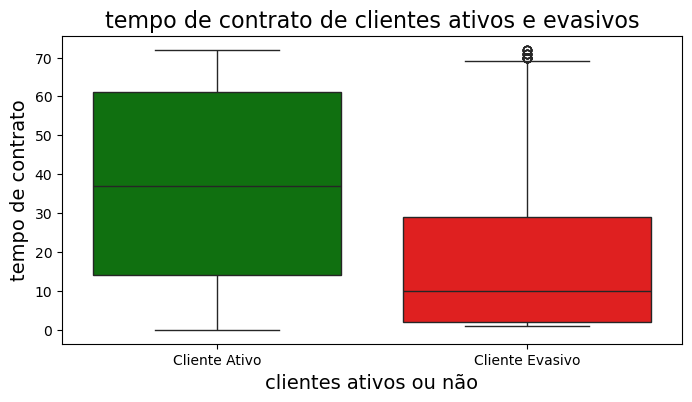

In [75]:
fig, ax = plt.subplots(figsize=(8, 4))

ax = sns.boxplot(data=df, y='tenure', x='Churn', palette=['green', 'red'])
ax.set_title('tempo de contrato de clientes ativos e evasivos', fontsize=16)
ax.set_ylabel('tempo de contrato', fontsize=14)
ax.set_xlabel('clientes ativos ou não', fontsize=14)
ax.set_xticklabels(['Cliente Ativo', 'Cliente Evasivo'])

Nesta análise podemos notar facilmente que os clientes que se mantem por mais tempo de contrato, possuem maior aderência na empresa


##  Conclusão

A análise dos dados de churn da Telecom X revelou padrões claros e acionáveis sobre o comportamento dos clientes evasivos. Aproximadamente 25% da base de clientes abandonou a empresa, concentrando-se principalmente em clientes com contratos mensais (88.6%) e que utilizam cheque eletrônico como método de pagamento (57%). O tipo de contrato emergiu como o fator mais determinante para a retenção, uma vez que clientes com contratos de 1 ou 2 anos demonstraram maior fidelidade à empresa, representando 25.1% e 31.4% respectivamente da base de clientes ativos.

O tempo de permanência na empresa mostrou uma correlação direta com o gasto total dos clientes e sua propensão à permanência. Clientes que permanecem mais tempo tendem a investir mais nos serviços oferecidos, criando um ciclo virtuoso de engajamento e fidelização. Por outro lado, o fator idade não se mostrou relevante para determinar a evasão, indicando que as estratégias de retenção devem focar em outros aspectos comportamentais e contratuais.

##  Recomendações

Com base nos insights obtidos, recomenda-se que a Telecom X implemente uma estratégia de retenção focada na migração de clientes mensais para contratos de maior duração. A empresa deve desenvolver campanhas promocionais atrativas para incentivar a conversão de contratos mensais para anuais ou bianuais, oferecendo benefícios tangíveis como descontos progressivos, serviços adicionais gratuitos ou upgrades de plano.

A diversificação dos métodos de pagamento também merece atenção especial, uma vez que clientes que dependem exclusivamente do cheque eletrônico apresentam maior risco de evasão. A implementação de programas de incentivo para migração para métodos de pagamento automáticos, como débito em conta ou cartão de crédito, pode reduzir significativamente a taxa de churn.

Adicionalmente, sugere-se o desenvolvimento de um programa de fidelidade que reconheça e recompense clientes de longa data, criando barreiras emocionais e financeiras para a saída. A combinação dessas estratégias, focadas nos fatores identificados como mais relevantes, tem potencial para reduzir substancialmente a taxa de evasão e aumentar o valor vitalício dos clientes da Telecom X.
